# Chapter 11

### 交叉驗證模型

In [6]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [19]:
digits = datasets.load_digits()
features = digits.data
target = digits.target
standardizer = StandardScaler()
logit = LogisticRegression()
# 產生用來標準化then邏輯回歸的pipeline
pipeline = make_pipeline(standardizer, logit)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

cv_results = cross_val_score(pipeline, features, target, cv=kf, scoring="accuracy") # cpu
cv_results.mean()

0.964931719428926

In [20]:
cv_results

array([0.97222222, 0.97777778, 0.95555556, 0.95      , 0.95555556,
       0.98333333, 0.97777778, 0.96648045, 0.96089385, 0.94972067])

#### Notes: KFCV
#### 1. KSCV假設資料是IID(Shuffle=True)
#### 2. KSCV評估分類器時，讓每組內含每一個不同目標分類中相近百分比的觀察數會更好(Stratified k-fold)
#### 3. 當我們使用驗證集或交叉驗證時，要先依照訓練集做前處理，然後套用到訓練集和測試集上。例如:fit標準化物件時，我們只計算訓練集的平均和變異，接著才套用transform到訓練集和測試集上。

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=1)
standardizer.fit(X_train)

features_train_std = standardizer.transform(X_train)
features_test_std = standardizer.transform(X_test)

### 產生基線回歸模型

In [26]:
from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
boston = load_boston()
features, target = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)
# 產生虛擬回歸變量
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.001119359203955339

In [28]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X_train, y_train)
# 取得R-square score
ols.score(X_test, y_test)

0.6354638433202128

#### 也可以用其他方式，例如中位數值，但若設成constant可以設定虛擬回歸變量來預測每一個觀察的某些常數

In [29]:
clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

-0.06510502029325727

$$ R^2=1-\frac{\sum_{i}(y_i-\hat{y_i})^2}{\sum_{i}(y_i-\bar{y})^2} $$
$$y_i是目標觀察的真值，\hat{y_i}是預測值，\bar{y}目標向量平均值$$
$$R^2越接近1，目標向量中可被特徵解釋的變異就越多$$

### 產生基線分類模型

In [36]:
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

iris = load_iris()
features, target = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

dummy = DummyClassifier(strategy='uniform', random_state=1) # 假設有兩類，則會產生50%、50%的預測
# strategy=stratified
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

0.42105263157894735

In [37]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.9736842105263158

### 二元分類器預測之評估

$$Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 10000,
                           n_features = 3,
                           n_informative = 3,
                           n_redundant = 0,
                           n_classes = 2,
                           random_state = 1)
logit = LogisticRegression()
cross_val_score(logit, X, y, scoring="accuracy")

array([0.95170966, 0.9580084 , 0.95558223])

$$Precision=\frac{TP}{TP+FP}$$

In [8]:
cross_val_score(logit, X, y, scoring="precision")

array([0.95252404, 0.96583282, 0.95558223])

$$Recall=\frac{TP}{TP+FN}$$

In [10]:
cross_val_score(logit, X, y, scoring="recall")

array([0.95080984, 0.94961008, 0.95558223])

$$F_1=2 \times \frac{Precision\times Recall}{Precision+Recall}$$

In [11]:
cross_val_score(logit, X, y, scoring="f1")

array([0.95166617, 0.95765275, 0.95558223])

#### Notes: 有真實y值與預測y值，直接計算。

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
y_hat = logit.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_hat)

0.947

### 二元分類器門檻值評估

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

features, target = make_classification(n_samples=10000, n_features=10, n_classes=2, n_informative=3, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.1, random_state=1)
logit = LogisticRegression()
logit.fit(X_train, y_train)
# 計算預測機率
target_proba = logit.predict_proba(X_test)[:,1]

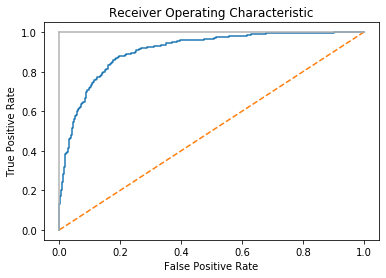

In [26]:
# 計算FPR, TPR
fpr, tpr, threshold = roc_curve(y_test, target_proba)
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.plot([0, 1], "--")
plt.plot([0, 0], [1, 0], c=".7")
plt.plot([1, 1], c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

#### Notes:

In [28]:
# 第一個觀察的預測機率
logit.predict_proba(X_test)[0:1]

array([[0.8688938, 0.1311062]])

In [29]:
# 取得分類，對應上述
logit.classes_

array([0, 1])

$$TPR=\frac{True Positives}{True Positives+False Negatives}$$

$$FPR=\frac{False Positives}{False Positives+True Negatives}$$

In [31]:
print("Threshold:", threshold[116])
print("True Positive Rate:", tpr[116])
print("False Positive Rate:", fpr[116])

Threshold: 0.5332422684258307
True Positive Rate: 0.810204081632653
False Positive Rate: 0.14901960784313725


#### The area under the ROC curve (AUC)

In [34]:
roc_auc_score(y_test, target_proba)

0.9073389355742297

### 多類型分類器預設之評估

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [15]:
features, target = make_classification(n_samples = 10000,n_features = 3, n_informative = 3, n_redundant = 0, n_classes =3, random_state =1)
logit = LogisticRegression(solver="lbfgs", multi_class="auto")
cross_val_score(logit, X=features,  y=target, scoring="accuracy", cv=3)

array([0.83503299, 0.82958296, 0.81278128])

In [17]:
cross_val_score(logit, X=features, y=target, scoring='f1_macro', cv=3)

array([0.83477937, 0.82931964, 0.81275734])

#### macro: 計算每一分類指標分數的平均，每一分類的權重相等
#### weighted: 計算每一分類指標分數平均，以資料中的分類大小作為權重的比例
#### micro: 計算每一觀察 - 分類組合之指標分數的平均值

### 分類器效能視覺化

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

In [32]:
iris = datasets.load_iris()
features, target = iris.data, iris.target
class_names = iris.target_names
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

C:\Users\sychen\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sychen\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [55]:
matrix = confusion_matrix(y_test, y_pred)
matrix
df = pd.DataFrame(matrix, index=class_names, columns=class_names) # 為了上標籤

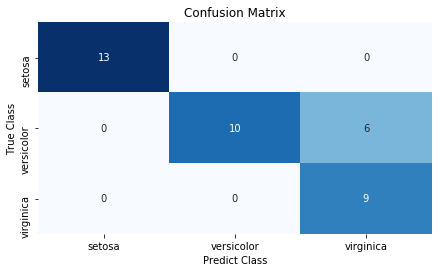

In [60]:
heatmap = sns.heatmap(df, 
            annot=True, # 裡面要不要顯示數字
            cbar=None, # 旁邊的色調比對表
            cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predict Class")
# matplot 新版的bug.. solution
#---
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
#---
plt.show()

#### Notes: 完美的模型只會在對角線上有值，不好的模型會平均分散在矩陣中。（但類型過多時不好判讀）

### 回歸模型評估

In [70]:
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

features, target = make_regression(n_samples=100,
                                  n_features=3,
                                  n_informative=3,
                                  n_targets=1,
                                  noise=50,
                                  coef=False,
                                  random_state=1)
lr = LinearRegression()
cross_val_score(lr, features, target, scoring="neg_mean_squared_error", cv=3)

array([-1718.22817783, -3103.4124284 , -1377.17858823])

In [73]:
# R-square
cross_val_score(lr, features, target, scoring="r2", cv=3)

array([0.87804558, 0.76395862, 0.89154377])

#### Notes: $$MSE=\frac{1}{n_i}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$$
$$\hat{y_i}為模型預測值，y_i為目標真值$$

$$R^2=1-\frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$$

### 分群模型評估(Silhouette coefficient)

In [77]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [80]:
features, _ = make_blobs(n_samples=1000,
                        n_features=10,
                        centers=2,
                        cluster_std=0.5,
                        shuffle=True,
                        random_state=1)
model = KMeans(n_clusters=2, random_state=1)
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [85]:
y_pred = model.labels_
silhouette_score(features, y_pred) # 通常是不會有features..

0.8916265564072142

#### Notes: Silhouette coefficients(輪廓係數)
$$s_i=\frac{b_i-a_i}{\max(a_i,b_i)}$$
$$a_i是i與同一分群中所有其他觀察值的平均距離，b_i是i與不同分類下最鄰近分群中所有其他觀察值的平均距離$$
$$係數範圍為Range(-1,1)，1表密集且分散情形良好的分群$$